In [ ]:
!pip install umap-learn
!pip install cleverhans
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=dc14de1ef260102c305b02a2517cd8f3d961b26501de700aa1c9bdd20440be98
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=78d5f72b6efeec3fa47031436a2d96aef071e28e57ceca26b6c52f0474780d80
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [ ]:
## import necessary libraries
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from torch import optim, nn
import torch

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from pytorch_metric_learning import losses, reducers

In [ ]:
batch_size = 64
epochs = 100

## load data

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images, targets, train_portion=.2, train=True, cls_num=10, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        train_indices = []
        test_indices = []
        for cls in range(cls_num):
            idx = np.where(np.array(targets)==cls)[0]
            cls_train_idx = np.random.choice(idx, int(train_portion*len(idx)), replace=False)
            cls_test_idx = np.setdiff1d(idx, cls_train_idx)
            train_indices.extend(cls_train_idx)
            test_indices.extend(cls_test_idx)
        
        if train:
            self.images = images[train_indices]
            self.targets = targets[train_indices]
        else:
            self.images = images[test_indices]
            self.targets = targets[test_indices]
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

In [ ]:
train_data = CIFAR10(root="data", download=True, train=True)
test_data = CIFAR10(root="data", download=True, train=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 90679877.89it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
all_images = np.append(train_data.data, test_data.data, axis=0)
all_labels = np.append(train_data.targets, test_data.targets, axis=0)

In [ ]:
train_dataset = CustomImageDataset(all_images, all_labels, train=True, transform=transforms.ToTensor())
test_dataset = CustomImageDataset(all_images, all_labels, train=False, transform=transforms.ToTensor())

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## train 

In [ ]:
def plot_diagram(train_acc, train_loss, valid_acc, valid_loss, title):
  # accuracy plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
  fig.suptitle(title)
  ax1.plot(
      train_acc, color='green', linestyle='-', 
      label='train accuracy'
  )
  ax1.plot(
      valid_acc, color='blue', linestyle='-', 
      label='validataion accuracy'
  )
  ax1.set(xlabel='Epochs', ylabel='Accuracy')
  ax1.legend()
  # loss plots
  ax2.plot(
      train_loss, color='orange', linestyle='-', 
      label='train loss'
  )
  ax2.plot(
      valid_loss, color='red', linestyle='-', 
      label='validataion loss'
  )
  ax2.set(xlabel='Epochs', ylabel='Loss')
  ax2.legend()
  plt.show()

In [ ]:
# training
def train(model, trainloader, optimizer, criterion):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / total)
    return epoch_loss, epoch_acc

In [ ]:
# validation
def validate(model, testloader, criterion):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    total = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            total += labels.size(0)
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / total)
    return epoch_loss, epoch_acc

In [ ]:
model = resnet18()
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
# the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [ ]:
# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_dataloader,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 100
Training


100%|██████████| 188/188 [00:09<00:00, 20.05it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 156.58it/s]




Training loss: 1.921, training acc: 33.150
Validation loss: 2.346, validation acc: 33.150
--------------------------------------------------
[INFO]: Epoch 2 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 68.14it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 164.99it/s]




Training loss: 1.529, training acc: 46.867
Validation loss: 1.369, validation acc: 50.794
--------------------------------------------------
[INFO]: Epoch 3 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.99it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.11it/s]




Training loss: 1.343, training acc: 52.742
Validation loss: 1.456, validation acc: 48.627
--------------------------------------------------
[INFO]: Epoch 4 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 67.55it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 154.18it/s]




Training loss: 1.185, training acc: 58.567
Validation loss: 1.621, validation acc: 51.367
--------------------------------------------------
[INFO]: Epoch 5 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 67.74it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 174.86it/s]




Training loss: 1.038, training acc: 64.225
Validation loss: 1.426, validation acc: 52.362
--------------------------------------------------
[INFO]: Epoch 6 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 65.12it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.64it/s]




Training loss: 0.879, training acc: 69.175
Validation loss: 1.600, validation acc: 49.019
--------------------------------------------------
[INFO]: Epoch 7 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 66.96it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.74it/s]




Training loss: 0.741, training acc: 74.167
Validation loss: 1.379, validation acc: 57.842
--------------------------------------------------
[INFO]: Epoch 8 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 56.35it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 175.16it/s]




Training loss: 0.633, training acc: 77.933
Validation loss: 1.165, validation acc: 64.181
--------------------------------------------------
[INFO]: Epoch 9 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 67.03it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 154.45it/s]




Training loss: 0.507, training acc: 81.925
Validation loss: 1.276, validation acc: 60.950
--------------------------------------------------
[INFO]: Epoch 10 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 65.66it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.02it/s]




Training loss: 0.433, training acc: 85.100
Validation loss: 1.592, validation acc: 59.062
--------------------------------------------------
[INFO]: Epoch 11 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.01it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.23it/s]




Training loss: 0.363, training acc: 87.400
Validation loss: 1.486, validation acc: 61.246
--------------------------------------------------
[INFO]: Epoch 12 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 65.51it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.86it/s]




Training loss: 0.291, training acc: 89.975
Validation loss: 1.390, validation acc: 64.650
--------------------------------------------------
[INFO]: Epoch 13 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 64.94it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.69it/s]




Training loss: 0.245, training acc: 91.650
Validation loss: 1.493, validation acc: 64.056
--------------------------------------------------
[INFO]: Epoch 14 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 64.36it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.89it/s]




Training loss: 0.231, training acc: 91.958
Validation loss: 1.797, validation acc: 61.877
--------------------------------------------------
[INFO]: Epoch 15 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 64.50it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.94it/s]




Training loss: 0.179, training acc: 93.775
Validation loss: 1.552, validation acc: 65.852
--------------------------------------------------
[INFO]: Epoch 16 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 59.73it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.40it/s]




Training loss: 0.149, training acc: 94.983
Validation loss: 1.677, validation acc: 64.706
--------------------------------------------------
[INFO]: Epoch 17 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.25it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 152.75it/s]




Training loss: 0.145, training acc: 95.142
Validation loss: 1.673, validation acc: 66.404
--------------------------------------------------
[INFO]: Epoch 18 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.05it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 169.57it/s]




Training loss: 0.129, training acc: 95.492
Validation loss: 1.623, validation acc: 66.815
--------------------------------------------------
[INFO]: Epoch 19 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 59.93it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 164.20it/s]




Training loss: 0.132, training acc: 95.450
Validation loss: 1.672, validation acc: 67.017
--------------------------------------------------
[INFO]: Epoch 20 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.91it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 158.29it/s]




Training loss: 0.110, training acc: 96.150
Validation loss: 1.704, validation acc: 65.958
--------------------------------------------------
[INFO]: Epoch 21 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.76it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 172.19it/s]




Training loss: 0.092, training acc: 96.733
Validation loss: 1.663, validation acc: 67.315
--------------------------------------------------
[INFO]: Epoch 22 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.15it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 151.00it/s]




Training loss: 0.081, training acc: 97.192
Validation loss: 1.717, validation acc: 67.071
--------------------------------------------------
[INFO]: Epoch 23 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.79it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.73it/s]




Training loss: 0.075, training acc: 97.508
Validation loss: 1.660, validation acc: 67.112
--------------------------------------------------
[INFO]: Epoch 24 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 59.68it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.72it/s]




Training loss: 0.070, training acc: 97.742
Validation loss: 1.701, validation acc: 68.340
--------------------------------------------------
[INFO]: Epoch 25 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 64.04it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 154.45it/s]




Training loss: 0.060, training acc: 98.042
Validation loss: 1.607, validation acc: 68.708
--------------------------------------------------
[INFO]: Epoch 26 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.71it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 169.71it/s]




Training loss: 0.057, training acc: 97.992
Validation loss: 1.744, validation acc: 67.683
--------------------------------------------------
[INFO]: Epoch 27 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.85it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 160.61it/s]




Training loss: 0.063, training acc: 97.767
Validation loss: 1.906, validation acc: 65.823
--------------------------------------------------
[INFO]: Epoch 28 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.33it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 163.65it/s]




Training loss: 0.063, training acc: 97.792
Validation loss: 1.656, validation acc: 68.342
--------------------------------------------------
[INFO]: Epoch 29 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.18it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.95it/s]




Training loss: 0.045, training acc: 98.442
Validation loss: 1.910, validation acc: 66.935
--------------------------------------------------
[INFO]: Epoch 30 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.49it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 152.87it/s]




Training loss: 0.046, training acc: 98.450
Validation loss: 1.792, validation acc: 68.481
--------------------------------------------------
[INFO]: Epoch 31 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.41it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.82it/s]




Training loss: 0.041, training acc: 98.667
Validation loss: 1.796, validation acc: 69.167
--------------------------------------------------
[INFO]: Epoch 32 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.00it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.62it/s]




Training loss: 0.038, training acc: 98.725
Validation loss: 1.784, validation acc: 68.402
--------------------------------------------------
[INFO]: Epoch 33 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.99it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 154.21it/s]




Training loss: 0.047, training acc: 98.642
Validation loss: 1.783, validation acc: 68.108
--------------------------------------------------
[INFO]: Epoch 34 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.66it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 168.22it/s]




Training loss: 0.057, training acc: 98.075
Validation loss: 1.695, validation acc: 68.665
--------------------------------------------------
[INFO]: Epoch 35 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.38it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 154.60it/s]




Training loss: 0.045, training acc: 98.683
Validation loss: 1.713, validation acc: 68.010
--------------------------------------------------
[INFO]: Epoch 36 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.44it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 163.76it/s]




Training loss: 0.029, training acc: 99.083
Validation loss: 1.796, validation acc: 68.225
--------------------------------------------------
[INFO]: Epoch 37 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.49it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.74it/s]




Training loss: 0.042, training acc: 98.758
Validation loss: 1.867, validation acc: 67.923
--------------------------------------------------
[INFO]: Epoch 38 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.96it/s]


Validation


100%|██████████| 750/750 [00:05<00:00, 148.17it/s]




Training loss: 0.044, training acc: 98.408
Validation loss: 1.873, validation acc: 67.535
--------------------------------------------------
[INFO]: Epoch 39 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.32it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 172.21it/s]




Training loss: 0.032, training acc: 99.067
Validation loss: 1.830, validation acc: 68.917
--------------------------------------------------
[INFO]: Epoch 40 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 59.79it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 167.46it/s]




Training loss: 0.040, training acc: 98.675
Validation loss: 1.767, validation acc: 68.810
--------------------------------------------------
[INFO]: Epoch 41 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.15it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.38it/s]




Training loss: 0.056, training acc: 98.000
Validation loss: 1.831, validation acc: 66.160
--------------------------------------------------
[INFO]: Epoch 42 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.95it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 167.69it/s]




Training loss: 0.050, training acc: 98.242
Validation loss: 1.723, validation acc: 68.617
--------------------------------------------------
[INFO]: Epoch 43 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.20it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 154.07it/s]




Training loss: 0.039, training acc: 98.650
Validation loss: 1.712, validation acc: 68.640
--------------------------------------------------
[INFO]: Epoch 44 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.21it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 163.10it/s]




Training loss: 0.031, training acc: 98.933
Validation loss: 1.769, validation acc: 68.906
--------------------------------------------------
[INFO]: Epoch 45 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 59.65it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.70it/s]




Training loss: 0.035, training acc: 98.842
Validation loss: 1.767, validation acc: 67.810
--------------------------------------------------
[INFO]: Epoch 46 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.65it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.25it/s]




Training loss: 0.055, training acc: 98.008
Validation loss: 1.744, validation acc: 68.083
--------------------------------------------------
[INFO]: Epoch 47 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.58it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.53it/s]




Training loss: 0.042, training acc: 98.592
Validation loss: 1.761, validation acc: 68.463
--------------------------------------------------
[INFO]: Epoch 48 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.69it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 165.66it/s]




Training loss: 0.037, training acc: 98.650
Validation loss: 1.883, validation acc: 67.181
--------------------------------------------------
[INFO]: Epoch 49 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.60it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 158.58it/s]




Training loss: 0.060, training acc: 98.075
Validation loss: 1.905, validation acc: 65.910
--------------------------------------------------
[INFO]: Epoch 50 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.00it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 169.80it/s]




Training loss: 0.040, training acc: 98.642
Validation loss: 1.678, validation acc: 69.542
--------------------------------------------------
[INFO]: Epoch 51 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.12it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 151.64it/s]




Training loss: 0.037, training acc: 98.775
Validation loss: 1.725, validation acc: 68.985
--------------------------------------------------
[INFO]: Epoch 52 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.02it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.92it/s]




Training loss: 0.024, training acc: 99.133
Validation loss: 1.819, validation acc: 68.292
--------------------------------------------------
[INFO]: Epoch 53 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.01it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.20it/s]




Training loss: 0.030, training acc: 98.975
Validation loss: 1.775, validation acc: 68.715
--------------------------------------------------
[INFO]: Epoch 54 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.15it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 151.75it/s]




Training loss: 0.031, training acc: 98.983
Validation loss: 1.973, validation acc: 66.948
--------------------------------------------------
[INFO]: Epoch 55 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.43it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.07it/s]




Training loss: 0.036, training acc: 98.742
Validation loss: 1.764, validation acc: 69.198
--------------------------------------------------
[INFO]: Epoch 56 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.03it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.42it/s]




Training loss: 0.035, training acc: 98.825
Validation loss: 1.758, validation acc: 68.892
--------------------------------------------------
[INFO]: Epoch 57 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.79it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 158.53it/s]




Training loss: 0.032, training acc: 98.917
Validation loss: 1.794, validation acc: 68.758
--------------------------------------------------
[INFO]: Epoch 58 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.87it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 168.59it/s]




Training loss: 0.034, training acc: 98.800
Validation loss: 1.758, validation acc: 68.783
--------------------------------------------------
[INFO]: Epoch 59 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.55it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.82it/s]




Training loss: 0.049, training acc: 98.342
Validation loss: 1.688, validation acc: 68.340
--------------------------------------------------
[INFO]: Epoch 60 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.04it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 168.51it/s]




Training loss: 0.046, training acc: 98.475
Validation loss: 1.775, validation acc: 67.588
--------------------------------------------------
[INFO]: Epoch 61 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.75it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 172.59it/s]




Training loss: 0.053, training acc: 98.200
Validation loss: 1.637, validation acc: 68.302
--------------------------------------------------
[INFO]: Epoch 62 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.91it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 152.04it/s]




Training loss: 0.028, training acc: 99.067
Validation loss: 1.602, validation acc: 69.527
--------------------------------------------------
[INFO]: Epoch 63 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.78it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.85it/s]




Training loss: 0.031, training acc: 98.992
Validation loss: 1.712, validation acc: 69.644
--------------------------------------------------
[INFO]: Epoch 64 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.71it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.81it/s]




Training loss: 0.035, training acc: 98.808
Validation loss: 1.704, validation acc: 68.796
--------------------------------------------------
[INFO]: Epoch 65 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.87it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 165.93it/s]




Training loss: 0.022, training acc: 99.283
Validation loss: 1.657, validation acc: 69.837
--------------------------------------------------
[INFO]: Epoch 66 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.05it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.23it/s]




Training loss: 0.016, training acc: 99.442
Validation loss: 1.712, validation acc: 69.935
--------------------------------------------------
[INFO]: Epoch 67 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.55it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.79it/s]




Training loss: 0.024, training acc: 99.192
Validation loss: 1.758, validation acc: 69.196
--------------------------------------------------
[INFO]: Epoch 68 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.61it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 172.78it/s]




Training loss: 0.018, training acc: 99.358
Validation loss: 1.720, validation acc: 69.777
--------------------------------------------------
[INFO]: Epoch 69 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.83it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 168.55it/s]




Training loss: 0.046, training acc: 98.492
Validation loss: 1.778, validation acc: 67.696
--------------------------------------------------
[INFO]: Epoch 70 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.97it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 157.75it/s]




Training loss: 0.047, training acc: 98.425
Validation loss: 1.744, validation acc: 67.627
--------------------------------------------------
[INFO]: Epoch 71 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.15it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 172.10it/s]




Training loss: 0.038, training acc: 98.725
Validation loss: 1.837, validation acc: 66.235
--------------------------------------------------
[INFO]: Epoch 72 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.99it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.43it/s]




Training loss: 0.041, training acc: 98.750
Validation loss: 1.778, validation acc: 68.119
--------------------------------------------------
[INFO]: Epoch 73 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 64.05it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 173.72it/s]




Training loss: 0.022, training acc: 99.350
Validation loss: 1.661, validation acc: 69.867
--------------------------------------------------
[INFO]: Epoch 74 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 59.58it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 166.57it/s]




Training loss: 0.017, training acc: 99.450
Validation loss: 1.777, validation acc: 68.925
--------------------------------------------------
[INFO]: Epoch 75 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.81it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 151.73it/s]




Training loss: 0.031, training acc: 98.900
Validation loss: 1.760, validation acc: 68.802
--------------------------------------------------
[INFO]: Epoch 76 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.25it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 167.57it/s]




Training loss: 0.042, training acc: 98.633
Validation loss: 1.775, validation acc: 67.827
--------------------------------------------------
[INFO]: Epoch 77 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.01it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.70it/s]




Training loss: 0.039, training acc: 98.683
Validation loss: 1.715, validation acc: 68.296
--------------------------------------------------
[INFO]: Epoch 78 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.85it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 160.33it/s]




Training loss: 0.035, training acc: 98.817
Validation loss: 1.849, validation acc: 67.329
--------------------------------------------------
[INFO]: Epoch 79 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.03it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 173.35it/s]




Training loss: 0.056, training acc: 98.183
Validation loss: 1.675, validation acc: 67.844
--------------------------------------------------
[INFO]: Epoch 80 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 64.11it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.50it/s]




Training loss: 0.046, training acc: 98.600
Validation loss: 1.668, validation acc: 67.827
--------------------------------------------------
[INFO]: Epoch 81 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.97it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 172.02it/s]




Training loss: 0.031, training acc: 99.017
Validation loss: 1.672, validation acc: 68.617
--------------------------------------------------
[INFO]: Epoch 82 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.50it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.29it/s]




Training loss: 0.018, training acc: 99.392
Validation loss: 1.663, validation acc: 69.754
--------------------------------------------------
[INFO]: Epoch 83 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.58it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.48it/s]




Training loss: 0.026, training acc: 99.217
Validation loss: 1.721, validation acc: 69.260
--------------------------------------------------
[INFO]: Epoch 84 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.79it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 170.84it/s]




Training loss: 0.032, training acc: 98.950
Validation loss: 1.778, validation acc: 67.227
--------------------------------------------------
[INFO]: Epoch 85 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.99it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.85it/s]




Training loss: 0.032, training acc: 99.083
Validation loss: 1.655, validation acc: 68.469
--------------------------------------------------
[INFO]: Epoch 86 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.08it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 164.53it/s]




Training loss: 0.027, training acc: 99.033
Validation loss: 1.711, validation acc: 68.890
--------------------------------------------------
[INFO]: Epoch 87 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.32it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 167.73it/s]




Training loss: 0.035, training acc: 98.850
Validation loss: 1.747, validation acc: 67.848
--------------------------------------------------
[INFO]: Epoch 88 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.88it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.96it/s]




Training loss: 0.041, training acc: 98.583
Validation loss: 1.680, validation acc: 69.079
--------------------------------------------------
[INFO]: Epoch 89 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.61it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 169.73it/s]




Training loss: 0.038, training acc: 98.767
Validation loss: 1.741, validation acc: 68.069
--------------------------------------------------
[INFO]: Epoch 90 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.60it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 165.62it/s]




Training loss: 0.033, training acc: 98.983
Validation loss: 1.697, validation acc: 69.029
--------------------------------------------------
[INFO]: Epoch 91 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.01it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 152.99it/s]




Training loss: 0.023, training acc: 99.225
Validation loss: 1.986, validation acc: 64.867
--------------------------------------------------
[INFO]: Epoch 92 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.73it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 169.32it/s]




Training loss: 0.039, training acc: 98.700
Validation loss: 1.744, validation acc: 68.640
--------------------------------------------------
[INFO]: Epoch 93 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 62.24it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 155.88it/s]




Training loss: 0.050, training acc: 98.267
Validation loss: 1.589, validation acc: 69.156
--------------------------------------------------
[INFO]: Epoch 94 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.81it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 166.52it/s]




Training loss: 0.025, training acc: 99.175
Validation loss: 1.669, validation acc: 69.065
--------------------------------------------------
[INFO]: Epoch 95 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.31it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.84it/s]




Training loss: 0.024, training acc: 99.283
Validation loss: 1.690, validation acc: 69.290
--------------------------------------------------
[INFO]: Epoch 96 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.48it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 153.80it/s]




Training loss: 0.024, training acc: 99.200
Validation loss: 1.783, validation acc: 68.081
--------------------------------------------------
[INFO]: Epoch 97 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.48it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 168.06it/s]




Training loss: 0.049, training acc: 98.525
Validation loss: 1.842, validation acc: 66.379
--------------------------------------------------
[INFO]: Epoch 98 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.75it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 164.24it/s]




Training loss: 0.045, training acc: 98.650
Validation loss: 1.564, validation acc: 69.640
--------------------------------------------------
[INFO]: Epoch 99 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 63.31it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 158.91it/s]




Training loss: 0.028, training acc: 99.058
Validation loss: 1.618, validation acc: 69.565
--------------------------------------------------
[INFO]: Epoch 100 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.38it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 171.55it/s]



Training loss: 0.036, training acc: 98.708
Validation loss: 1.691, validation acc: 67.200
--------------------------------------------------


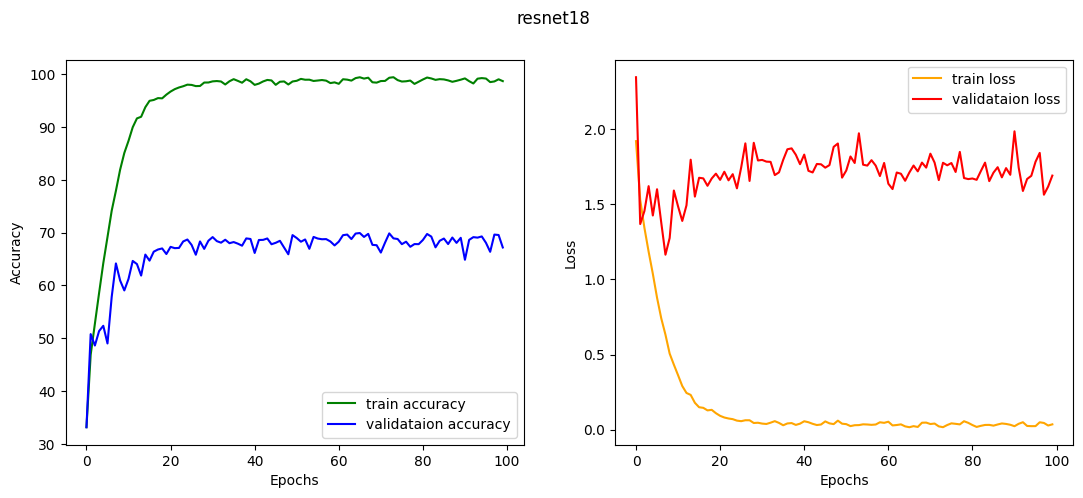

In [ ]:
plot_diagram(train_acc, train_loss, valid_acc, valid_loss, "resnet18")

In [ ]:
torch.save(model, "model.pt")

In [ ]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
model.layer4[1].bn2.register_forward_hook(get_features('backbone'))

## UMAP

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)
feature_maps = []
grandtruth = []
with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        images, labels = data
        images = images.to(device)
        # forward pass
        outputs = model(images)
        # get inner layer (backbone) output feature map
        feature_map = torch.flatten(features['backbone'], start_dim=1).cpu().numpy()
        feature_maps.extend(feature_map)
        grandtruth.extend(labels.numpy())

100%|██████████| 750/750 [00:06<00:00, 111.72it/s]


In [ ]:
%%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(feature_maps)

CPU times: user 54.2 s, sys: 1.56 s, total: 55.8 s
Wall time: 41.6 s


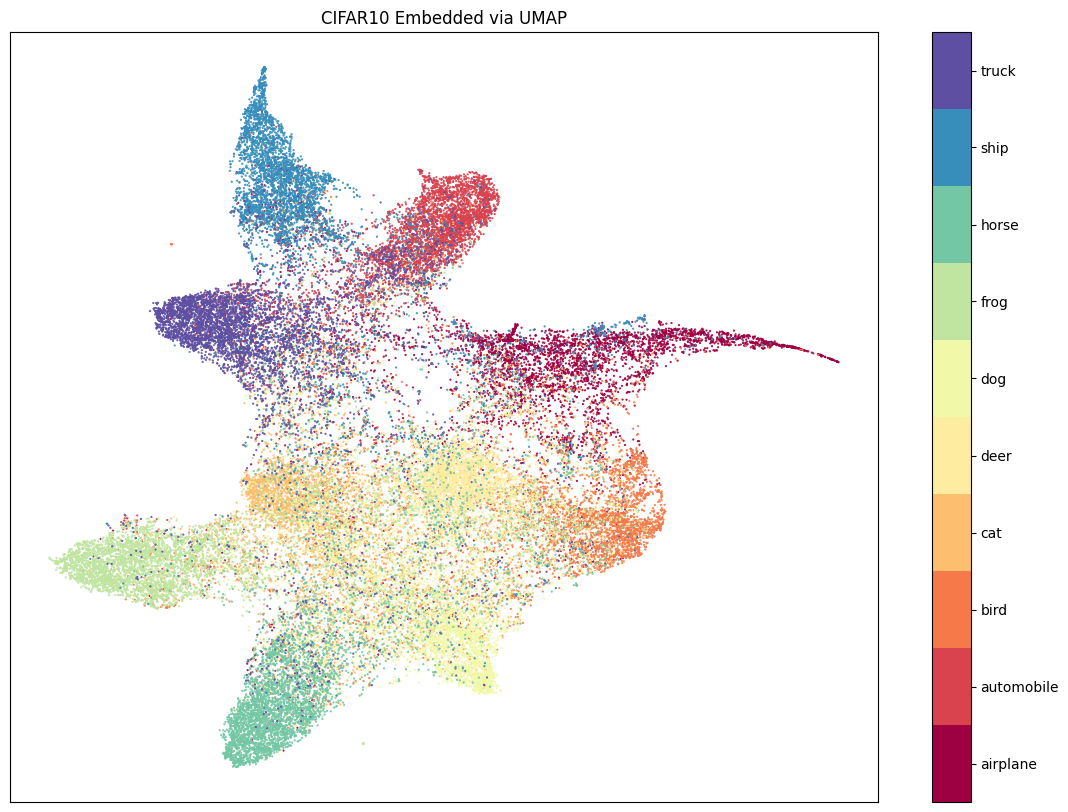

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=grandtruth, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(train_data.classes)
plt.title('CIFAR10 Embedded via UMAP');

## noise and attack

In [ ]:
noise_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(30),
        transforms.ElasticTransform(),
        transforms.RandomAffine(10),
        transforms.ColorJitter(),
        transforms.GaussianBlur(3),
        transforms.RandomSolarize(0.8),
        transforms.RandomAdjustSharpness(1.5),
        transforms.RandomAutocontrast(),
        transforms.RandomEqualize()
    ]),
    transforms.ToTensor(),
])

In [ ]:
noisy_test_dataset = CustomImageDataset(all_images, all_labels, train=False, transform=noise_transform)

In [ ]:
noisy_test_dataloader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model.to(device)
feature_maps = []
grandtruth = []
predicted = []
with torch.no_grad():
    for i, data in tqdm(enumerate(noisy_test_dataloader), total=len(noisy_test_dataloader)):
        images, labels = data
        images = images.to(device)
        # forward pass
        outputs = model(images)
        # get inner layer (backbone) output feature map
        feature_map = torch.flatten(features['backbone'], start_dim=1).cpu().numpy()
        feature_maps.extend(feature_map)
        grandtruth.extend(labels.numpy())
        predicted.extend(np.argmax(outputs.cpu().numpy(), 1))

100%|██████████| 750/750 [00:45<00:00, 16.46it/s]


In [ ]:
accuracy = accuracy_score(grandtruth, predicted)
print(accuracy)

0.5779583333333334


In [ ]:
%%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(feature_maps)

CPU times: user 34.1 s, sys: 1.35 s, total: 35.4 s
Wall time: 20.7 s


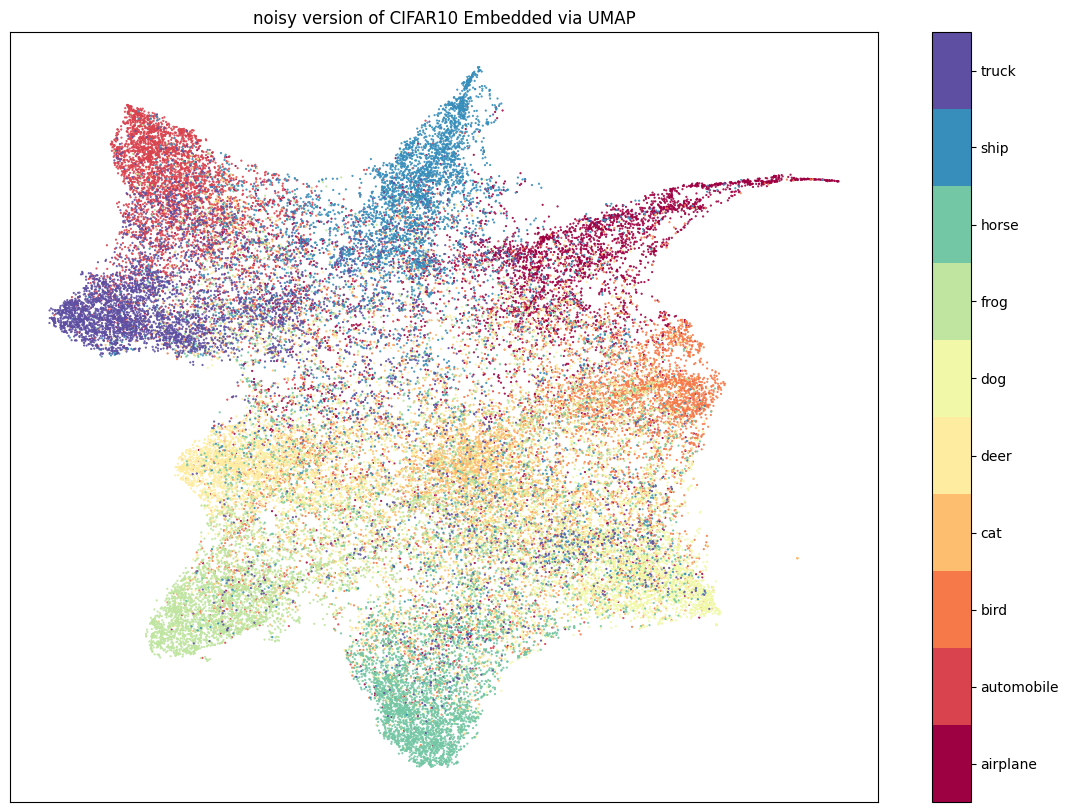

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=grandtruth, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(train_data.classes)
plt.title('noisy version of CIFAR10 Embedded via UMAP');

## attack


In [ ]:
model.to(device)
feature_maps = []
grandtruth = []
predicted = []
model.eval()
for i, data in tqdm(enumerate(noisy_test_dataloader), total=len(noisy_test_dataloader)):
    images, labels = data
    images = images.to(device)
    if np.random.random()<0.5:
        images = fast_gradient_method(model, images, 0.05, np.inf)
    # forward pass
    outputs = model(images)
    # get inner layer (backbone) output feature map
    feature_map = torch.flatten(features['backbone'], start_dim=1).cpu().numpy()
    feature_maps.extend(feature_map)
    grandtruth.extend(labels.numpy())
    predicted.extend(np.argmax(outputs.detach().cpu().numpy(), 1))

100%|██████████| 750/750 [01:03<00:00, 11.77it/s]


In [ ]:
%%time
embedding = umap.UMAP(n_neighbors=5).fit_transform(feature_maps)

CPU times: user 34.3 s, sys: 1.1 s, total: 35.4 s
Wall time: 20.5 s


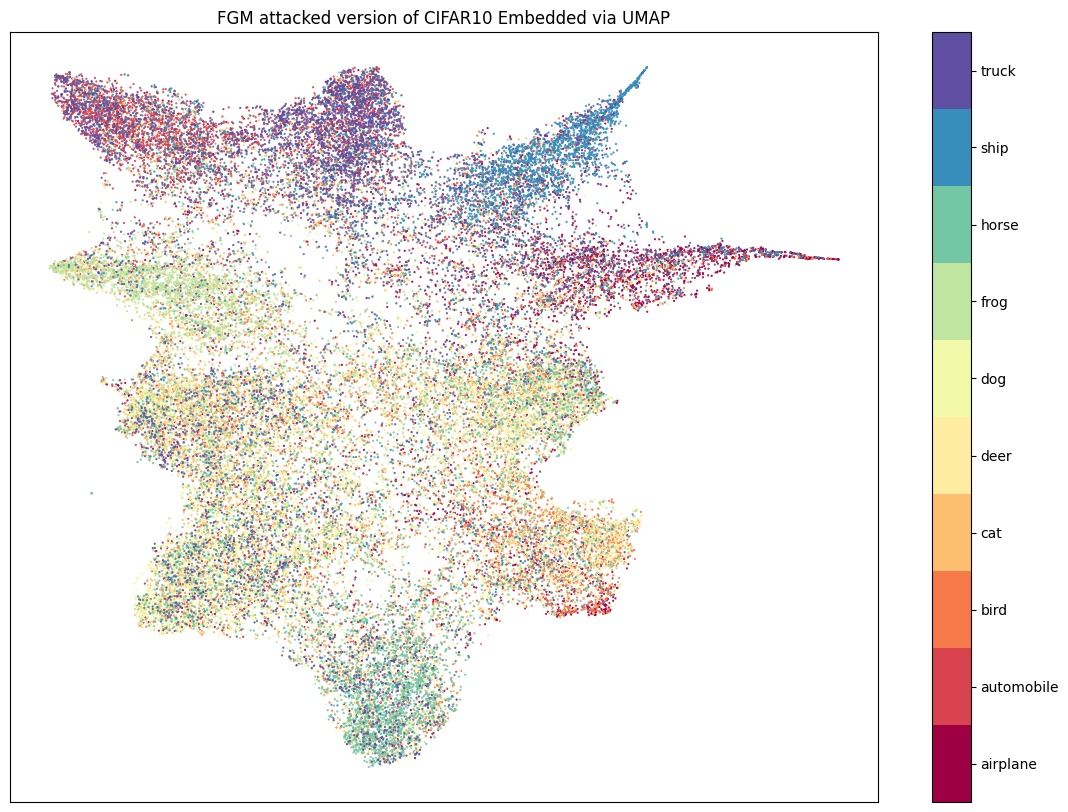

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=grandtruth, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(train_data.classes)
plt.title('FGM attacked version of CIFAR10 Embedded via UMAP');

## adversarial example

## metric learning


In [ ]:
class CustomSampler(Sampler):
    def __init__(self, data_source, batch_size, class_per_batch=3, sample_per_class=10):
        self.data_source = data_source
        self.classes = np.unique(data_source.targets)
        self.batch_size = batch_size
        self.class_per_batch = class_per_batch
        self.sample_per_class = sample_per_class

    def __iter__(self):
        for i in range(self.data_source.__len__()):
            selected_classes = np.random.choice(self.classes, size=self.class_per_batch, replace=False)
            indices = []
            for cls in selected_classes:
                class_data = np.where(np.array(self.data_source.targets)==cls)[0]
                selected_samples = np.random.choice(class_data, size=self.sample_per_class, replace=False)
                indices.extend(selected_samples)
            yield indices

    def __len__(self):
        return self.data_source.__len__()

In [ ]:
sampler = CustomSampler(train_dataset, batch_size=batch_size)
train_triplet_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

In [ ]:
for a,b in train_triplet_dataloader:
    print(a.shape)
    print(b)
    break

ValueError: ignored

In [ ]:
model_ang = resnet18()
model_ang.fc = nn.Linear(in_features=512, out_features=10, bias=True)
# the loss function
criterion = losses.AngularLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [ ]:
# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model_ang, train_dataloader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model_ang, test_dataloader,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 53.52it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 162.22it/s]




Training loss: 11.484, training acc: 10.733
Validation loss: 0.000, validation acc: 10.548
--------------------------------------------------
[INFO]: Epoch 2 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.53it/s]


Validation


100%|██████████| 750/750 [00:05<00:00, 146.01it/s]




Training loss: 11.470, training acc: 10.675
Validation loss: 0.000, validation acc: 10.494
--------------------------------------------------
[INFO]: Epoch 3 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.48it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 162.45it/s]




Training loss: 11.505, training acc: 10.583
Validation loss: 0.000, validation acc: 10.567
--------------------------------------------------
[INFO]: Epoch 4 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 53.12it/s]


Validation


100%|██████████| 750/750 [00:05<00:00, 143.82it/s]




Training loss: 11.494, training acc: 10.825
Validation loss: 0.000, validation acc: 10.681
--------------------------------------------------
[INFO]: Epoch 5 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 60.55it/s]


Validation


100%|██████████| 750/750 [00:05<00:00, 145.97it/s]




Training loss: 11.495, training acc: 11.000
Validation loss: 0.000, validation acc: 10.804
--------------------------------------------------
[INFO]: Epoch 6 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 61.22it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.15it/s]




Training loss: 11.411, training acc: 10.633
Validation loss: 0.000, validation acc: 10.738
--------------------------------------------------
[INFO]: Epoch 7 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 56.99it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.70it/s]




Training loss: 11.444, training acc: 10.583
Validation loss: 0.000, validation acc: 10.571
--------------------------------------------------
[INFO]: Epoch 8 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.69it/s]


Validation


100%|██████████| 750/750 [00:05<00:00, 146.51it/s]




Training loss: 11.560, training acc: 10.542
Validation loss: 0.000, validation acc: 10.625
--------------------------------------------------
[INFO]: Epoch 9 of 100
Training


100%|██████████| 188/188 [00:02<00:00, 62.83it/s]


Validation


100%|██████████| 750/750 [00:04<00:00, 161.46it/s]




Training loss: 11.430, training acc: 10.717
Validation loss: 0.000, validation acc: 10.662
--------------------------------------------------
[INFO]: Epoch 10 of 100
Training


100%|██████████| 188/188 [00:03<00:00, 58.23it/s]


Validation


 61%|██████    | 458/750 [00:03<00:01, 149.69it/s]


KeyboardInterrupt: ignored

In [ ]:
plot_diagram(train_acc, train_loss, valid_acc, valid_loss, "resnet18 with angular loss")